# Week 5, Data science in Neuroscience


## Plan for this week

1. Introduction to pytorch
2. Tensors
3. Training loop in pytorch
4. A first neural network
5. Convolutional networks to process images

***


# Convolutional neural networks (CNN)

Date back to 1989 (Yann LeCun). 

Convolutional neural network revolutionized how images are processed by neural network. 

They are used for all sorts of problems involving image processing.

The artificial neurons in the network have receptive fields, similar to what is observed in the visual system.

Why they work:

* They keep information about the spatial arrangement of the input image.
* Mechanism to detect a set a feature, independently of their position in the image. 

## Convolution 

<div>
<img src="../images/convolution1.png" width="800"/>
</div>

## LeNet: one of the first convolutional neural network.

LeCun et al. (1989). Backpropagation applied to handwritten zip code recognition. Neural Computation.


<div>
<img src="../images/LeNet5.png" width="1200"/>
</div>




## Convolutional Neural Networks as feature detectors


<div>
<img src="../images/imageNet_features_01.png" width="300"/>
</div>


<div>
<img src="../images/imageNet_features_02.png" width="600"/>
</div>



<div>
<img src="../images/imageNet_features_03.png" width="600"/>
</div>

<div>
<img src="../images/imageNet_features_04.png" width="600"/>
</div>



## ImageNet competition: 1.3 million images and 1000 classes

<div>
<img src="../images/imageNetResults.png" width="800"/>
</div>



# Let's build and train a convolutional neural network

Our aim will be to build a convolutional neural network to identify what object is in images. This is a classification problem.



## Dataset

We need a dataset of imagest to train our model.

We download our dataset using torchvision.datasets. We will use the CIFAR-10 dataset. It consists of 60000 small 32x32 color images.

https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html


In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy
import matplotlib.pyplot as plt

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
img,label = train_dataset[99]

In [6]:
img.shape

torch.Size([3, 32, 32])

The shame is [Color, Height, Width].

The first dimension of size 3 represent the color channels. In this case, we only have one color.

In [7]:
label

1

The labels are just numbers. We can associate a word to these numbers by creating a list of labels.

In [8]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
class_names[label]

'car'

Plot a few images and labels from our dataset.

In [10]:
img.squeeze().shape

torch.Size([3, 32, 32])

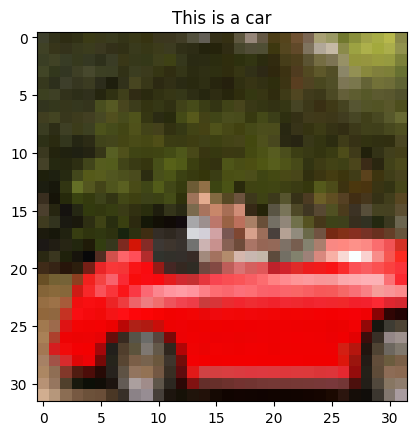

In [11]:
plt.imshow(img.permute(1,2,0)) # we use permute because imshow() wants [Height,Width,Color] and the tensor is [Color,Height,Width].
plt.title("This is a {}".format(class_names[label]))
plt.show()

## Exercise

Create a figure with several subplots. In each subplot, show the image with imshow() and put the label as title.

## Transforms and normalization

To facilitate learning:

* Normalize our input data so that they have a mean of 0 and a standard deviation of 1
* Make sure that all features or color channels have the same distribution. 

Making sure that the different features have the same distribution means that the choosen learning rate will be appropriate for all features. 



In [12]:
#a = torch.stack([img for img,_ in train_dataset],dim=3)
#a.shape
#a.view(3,-1).mean(1),a.view(3,-1).std(1)

In [13]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.4915,0.4823,0.4468), # means of each color channel
                                                                            (0.2470,0.2435,0.2616))]) # standard deviation of each color channel

# We pass the transform function to the dataset
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)




Files already downloaded and verified
Files already downloaded and verified


In [14]:
#a = torch.stack([img for img,_ in train_dataset],dim=3)
#a.shape
#a.view(3,-1).mean(1),a.view(3,-1).std(1)

In [15]:
img,label = train_dataset[99]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


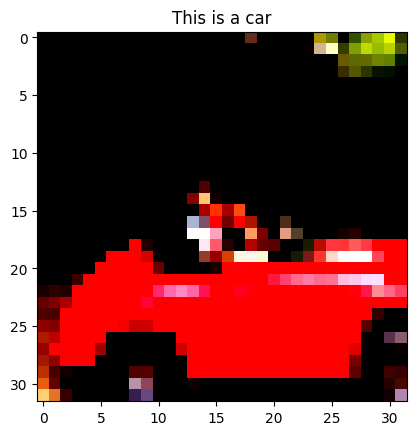

In [16]:
plt.imshow(img.permute(1,2,0)) # we use permute because imshow() wants H x W x C and the tensor is C X H X W.
plt.title("This is a {}".format(class_names[label]))
plt.show()

## Dataloader

We usually want to feed a few images at a time to our neural network. With large models and datasets, we would not be able to fit all that data in the GPU or computer memory. So we feed a few items at a time. 

The small group of images that we are feeding to the network simultaneously is called a `batch`.

The number of images that we feed to the neural network simultaneously is called the `batch size`.

pytorch has a `dataloader` class that can help you getting 

In [17]:
batch_size=4

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=2, 
                                           pin_memory=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=4)

In [18]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

In [19]:
images.shape

torch.Size([4, 3, 32, 32])

The shape is [Batch, Color, Height, Width].

In [20]:
labels.shape

torch.Size([4])

## Our model

We can build our model using the class from the last class.

<div>
<img src="../images/LeNet5.png" width="1200"/>
</div>



In [21]:
import torch.nn.functional as F
class Convolutional_model(nn.Module):
    """
    Class to create convolutional neural network.
    """
    def __init__(self):
        """
        Initializer. Runs when an object is created
        """
        super().__init__()
        
        
        # input images will be batch_size,3,32,32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 6, kernel_size=5,stride=1, padding=0)  # output shape: [batch_size, 6, 28, 28]
        self.pool1 = nn.MaxPool2d(kernel_size=2) # a max poll operation, # output shape: [batch_size, 6, 14,14]
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,stride=1, padding=0)  # output shape: [batch_size, 16, 10, 10]
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                                   # output shape: [batch_size, 16 , 5, 5]
        
        
        self.fc1 = nn.Linear(in_features = 16 * 5 * 5, out_features=120) # here we need to know the dimension of the data coming in (following second pool operation)
        self.fc2 = nn.Linear(in_features = 120, out_features =84)
        self.fc3 = nn.Linear(in_features = 84, out_features=10)
        
    def forward(self,x):
        """
        Make predictions with our model
        """

        # We have 2 x pool(relu(conv()))
        # This is the part extracting visual features
        
        # input shape [batch,3,32,32]
        x = F.relu(self.conv1(x)) # [batch, 6, 28, 28]
        x = self.pool1(x) # [batch, 6, 14, 14]
        
        x = F.relu(self.conv2(x)) # [batch, 16, 10, 10]
        x = self.pool2(x) # [batch, 16, 5, 5]

        # We then have 3 linear layers. These layers are take visual features as inputs and find a way to classify the image.
        x = torch.flatten(x, 1) # flatten all dimensions except batch, needed for the linear layer, [batch, 400]
        x = F.relu(self.fc1(x)) # [batch, 120]
        x = F.relu(self.fc2(x)) # [batch, 84]
        x = self.fc3(x) # [batch, 10]
        return x


**If you are implementing a model, start by passing the data through it line by line**

To follow how each layer in your network modify the dimension of the data flowing through the network, you can run it line by line.

In [22]:
conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1,padding=0)
pool1 = nn.MaxPool2d(kernel_size=2)
conv2 = nn.Conv2d(in_channels=6,out_channels=16, kernel_size=5, stride=1, padding=0)
pool2 = nn.MaxPool2d(kernel_size=2)

In [23]:
print("images.shape:",images.shape)
res = F.relu(conv1(images))
print("output of conv1 shape:", res.shape)
res = pool1(res)
print("output of pool shape:", res.shape)
res = F.relu(conv2(res))
print("output of conv2 shape:", res.shape)
res = pool2(res)
print("output of pool shape:", res.shape)

images.shape: torch.Size([4, 3, 32, 32])
output of conv1 shape: torch.Size([4, 6, 28, 28])
output of pool shape: torch.Size([4, 6, 14, 14])
output of conv2 shape: torch.Size([4, 16, 10, 10])
output of pool shape: torch.Size([4, 16, 5, 5])


In [24]:
conv_model = Convolutional_model()

In [25]:
#for name,p in conv_model.named_parameters():
#    print(name,p.shape,p)

In [26]:
print("Number of parameters:", sum(p.numel() for p in conv_model.parameters()))

Number of parameters: 62006


## Loss function

We need a loss function that works with categorical data. 

The last layer has an output size of 10, which is the number of categories we have in the dataset.

In [27]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.9)

## Training the model

In [28]:
def training_loop(n_epochs, optimizer, loss_fn, model, train_dataloader, test_dataloader):
    for epoch in range (n_epochs):
        
        loss_sum = 0.0
        for batch_no, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            data, labels = data
        
        
            yhat = model(data) # make predictions
            loss = loss_fn(yhat,labels) # calculate the loss
            
            optimizer.zero_grad() # zero the gradients of our model's parameters
            loss.backward() # calculate gradients of the model's parameters
            optimizer.step() # will change the model parameters to reduce the loss
        
            loss_sum = loss_sum + loss.item()
            
            if batch_no % 2000 == 1999:
                print("Epoch: {}, batch: {} Loss: {}".format(epoch,batch_no, loss_sum/2000))
                loss_sum=0.0
    return

In [29]:
training_loop(n_epochs=3,
              optimizer=optimizer,
              loss_fn=loss_fn,
              model=conv_model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader)

Epoch: 0, batch: 1999 Loss: 2.1502312347888948
Epoch: 0, batch: 3999 Loss: 1.752985846042633
Epoch: 0, batch: 5999 Loss: 1.6250043596923351
Epoch: 0, batch: 7999 Loss: 1.5480455251783132
Epoch: 0, batch: 9999 Loss: 1.478548425734043
Epoch: 0, batch: 11999 Loss: 1.455347571849823
Epoch: 1, batch: 1999 Loss: 1.3632015668451787
Epoch: 1, batch: 3999 Loss: 1.3444422507211566
Epoch: 1, batch: 5999 Loss: 1.3458413817547261
Epoch: 1, batch: 7999 Loss: 1.2990014576613904
Epoch: 1, batch: 9999 Loss: 1.3051448163315653
Epoch: 1, batch: 11999 Loss: 1.2639150146245957
Epoch: 2, batch: 1999 Loss: 1.2026023428365589
Epoch: 2, batch: 3999 Loss: 1.2076302549429239
Epoch: 2, batch: 5999 Loss: 1.2022928779181092
Epoch: 2, batch: 7999 Loss: 1.1903982744878159
Epoch: 2, batch: 9999 Loss: 1.1983077215515077
Epoch: 2, batch: 11999 Loss: 1.176746095146984


## Saving your model to file 

With larger models trained on large datasets, you will want to save your trained model so that you don't have to train it from scratch all the time.

In [30]:
file_name = '../models/cifar10_conv_model.pth'
torch.save(conv_model.state_dict(), file_name)

## Loading your model from file

In [31]:
file_name = '../models/cifar10_conv_model.pth'
loaded_state_dict = torch.load(file_name)

In [32]:
conv_model = Convolutional_model()
conv_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

## Evaluate our trained model

In [33]:
dataiter = iter(test_dataloader)

In [34]:
images, labels = next(dataiter)
labels

tensor([3, 8, 8, 0])

In [35]:
with torch.no_grad():
    res = conv_model(images)

In [36]:
res

tensor([[-0.9617, -0.5399, -0.7857,  1.4555, -0.2357,  1.7323, -1.0513,  0.7570,
         -0.4340,  0.5671],
        [ 5.3028,  9.5175, -3.3490, -4.0638, -3.5460, -5.6737, -2.5052, -6.0921,
          5.3037,  5.5765],
        [ 1.9319,  2.7439, -0.5220, -1.1251, -0.0719, -2.2358, -1.3244, -1.9506,
          2.0647,  1.4760],
        [ 1.9239,  2.3232, -1.0252, -1.4727, -0.9704, -2.2731, -2.0417, -1.4276,
          2.6754,  1.5120]])

We can use the `torch.max()` function to get the index with the highest value.

In [37]:
_, predictions = torch.max(res,1)

In [38]:
predictions

tensor([5, 1, 1, 8])

In [39]:
torch.sum(labels == predictions)

tensor(0)

In [40]:
def evaluate_model_accuracy(model, dataloader):
    """
    Function to calculate the classification accuracy of a model on a given dataset.
    """
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct*100/total, correct,total

In [41]:
train_accuracy,_,_ = evaluate_model_accuracy(conv_model,train_dataloader)
test_accuracy,_,_  = evaluate_model_accuracy(conv_model,test_dataloader)

In [42]:
print("Accuracy on training set:", train_accuracy)
print("Accuracy on test set:", test_accuracy)

Accuracy on training set: 61.626
Accuracy on test set: 57.59


In [43]:
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = conv_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 48.9 %
Accuracy for class: car   is 78.7 %
Accuracy for class: bird  is 44.0 %
Accuracy for class: cat   is 24.3 %
Accuracy for class: deer  is 61.5 %
Accuracy for class: dog   is 43.4 %
Accuracy for class: frog  is 75.0 %
Accuracy for class: horse is 66.8 %
Accuracy for class: ship  is 63.0 %
Accuracy for class: truck is 70.3 %


You now know how Google and co. classify the images that you upload to their servers.

## Let's have a look at the filter in our first layer

In [44]:
myIter = iter(conv_model.named_parameters())
name, param = next(myIter)

In [45]:
name, param.shape

('conv1.weight', torch.Size([6, 3, 5, 5]))

In [46]:
pmin = param.min().detach().numpy().item()
pmax = param.max().detach().numpy().item()
pmin,pmax

(-0.7277172803878784, 0.646938145160675)

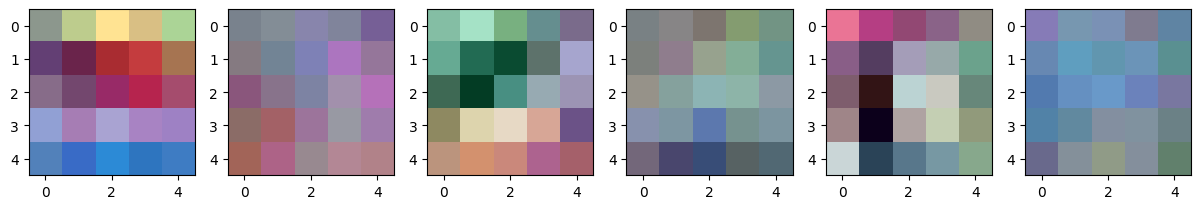

In [47]:
nrow=1
ncol=param.shape[0]
fig, ax = plt.subplots(nrow,ncol,figsize=(15,3))
for i in range(param.shape[0]):
    f = filter0 = param[i].permute(1,2,0).detach().numpy()
    f = (f-pmin)/(pmax-pmin)
    ax[i].imshow(f)
    

## Training networks using a GPU

In this notebook, we trained a very small convolutional neural network on a set of very small images. You can train these models with the CPU and it is almost as fast as using a GPU.

In most applications, you would be working with a larger convolutional network (e.g., [ResNet](https://pytorch.org/vision/main/models/resnet.html)) with images that are often more than 28x28 pixels (e.g., [ImageNet](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageNet.html)).

For such task, training is often more than 10x faster using a GPU instead of a CPU.


In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


You need to make two changes to run your model on a GPU (if you have one)

* Send the model to the GPU
* In the training loop, move your labels and images to the GPU

In [49]:
conv_model = Convolutional_model().to(device)
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.9)

In [50]:
def training_loop(n_epochs, optimizer, loss_fn, model, train_dataloader, test_dataloader,device):
    for epoch in range (n_epochs):
        
        loss_sum = 0.0
        for batch_no, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            data, labels = data
            data = data.to(device)
            labels = labels.to(device)
        
            yhat = model(data) # make predictions
            loss = loss_fn(yhat,labels) # calculate the loss
            
            optimizer.zero_grad() # zero the gradients of our model's parameters
            loss.backward() # calculate gradients of the model's parameters
            optimizer.step() # will change the model parameters to reduce the loss
        
            loss_sum = loss_sum + loss.item()
            
            if batch_no % 2000 == 1999:
                print("Epoch: {}, batch: {} Loss: {}".format(epoch,batch_no+1, loss_sum/2000))
                loss_sum=0.0
    return

In [51]:
%%time
training_loop(n_epochs=3,
              optimizer=optimizer,
              loss_fn=loss_fn,
              model=conv_model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             device=device)

Epoch: 0, batch: 2000 Loss: 2.1106125883460045
Epoch: 0, batch: 4000 Loss: 1.7368128111660481
Epoch: 0, batch: 6000 Loss: 1.5954589762985707
Epoch: 0, batch: 8000 Loss: 1.5135901090055703
Epoch: 0, batch: 10000 Loss: 1.4722749764099716
Epoch: 0, batch: 12000 Loss: 1.4169055113941431
Epoch: 1, batch: 2000 Loss: 1.346021385639906
Epoch: 1, batch: 4000 Loss: 1.3340802386328579
Epoch: 1, batch: 6000 Loss: 1.3128398756757378
Epoch: 1, batch: 8000 Loss: 1.2929458208121358
Epoch: 1, batch: 10000 Loss: 1.274698679715395
Epoch: 1, batch: 12000 Loss: 1.2658963941503316
Epoch: 2, batch: 2000 Loss: 1.1792703216560185
Epoch: 2, batch: 4000 Loss: 1.16826039968431
Epoch: 2, batch: 6000 Loss: 1.166512480167672
Epoch: 2, batch: 8000 Loss: 1.2012655458953232
Epoch: 2, batch: 10000 Loss: 1.1382859383532777
Epoch: 2, batch: 12000 Loss: 1.1751224763672798
CPU times: user 1min 36s, sys: 9.35 s, total: 1min 46s
Wall time: 1min 28s


If you load the train parameters from file, indicates on which device the parameters should be loaded.

In [57]:
file_name = '../models/cifar10_conv_model.pth'
loaded_state_dict = torch.load(file_name,map_location=device) # <- indicates whether the data should go to the GPU or CPU memory.

In [61]:
conv_model = Convolutional_model()
conv_model.load_state_dict(loaded_state_dict)
conv_model = conv_model.to(device)

In [62]:
def evaluate_model_accuracy(model, dataloader,device):
    """
    Function to calculate the classification accuracy of a model on a given dataset.
    """
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct*100/total, correct,total

In [63]:
train_accuracy,_,_ = evaluate_model_accuracy(conv_model,train_dataloader,device)
test_accuracy,_,_  = evaluate_model_accuracy(conv_model,test_dataloader,device)

In [64]:
print("Accuracy on training set:", train_accuracy)
print("Accuracy on test set:", test_accuracy)

Accuracy on training set: 61.626
Accuracy on test set: 57.59


## Exercises

Try modifying your convolutional neural network to improve classification accuracy on the test dataset. For example, by adding more convolutional filters?

Train a convolutional neural network to classifiy images of the MNIST dataset. In MNIST, the images have only one color channel instead of 3. They have a shape of (1,28,28).